In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
import seaborn as sns
  

In [3]:
data_dir = 'C:/Users/hs'

In [64]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize([224,224]),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize([256,256]),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/trainS', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/testC', transform=test_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True,num_workers=4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True,num_workers=4)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True,num_workers=4)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['Infected', 'Normal']


In [90]:
resnet18 = models.resnet18(pretrained=True)
# print(resnet18)

In [91]:
num_features = resnet18.fc.in_features
print(resnet18.fc)

fc =  nn.Sequential(nn.Linear(num_features,280),nn.ReLU(inplace=True),nn.Linear(280,2))
resnet18.fc=fc

Linear(in_features=512, out_features=1000, bias=True)


In [92]:
ct=0
for name, child in resnet18.named_children():
#     print('TOP',name)
    if ct < 9:
        for name2, params in child.named_parameters():
            params.requires_grad = False
#               print('Inside',name2)            
    ct += 1        
# print(resnet18.fc)

In [93]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name)

fc.0.weight
fc.0.bias
fc.2.weight
fc.2.bias


In [52]:
def accuracyE(model,Aloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in Aloader:
            images, labels = data
#             actualclasses.append(labels.tolist())
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
#             predictedclasses.append(predicted.tolist())
    #         print(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100*correct/total
#     print('Accuracy of the network on the 10000 test images: %d %%' % (
#         100 * correct / total))

In [94]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [54]:
comloss=[]
accuracy=[]
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
#     print(type(trainloader))

    pbar = tqdm(enumerate(trainloader))
    print(pbar)
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)#----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
#         print(loss.item())
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
    acc=accuracyE(resnet18,testloaderA)
    accuracy.append(acc)
    comloss.append(running_loss)    
    torch.save(resnet18.state_dict(), 'Resnet18_entire.pth')

print('Finished Training')


0it [00:00, ?it/s]

0it [00:00, ?it/s]



Train Epoch: 0 [0/3500 (0%)]	Loss: 0.789786: : 0it [01:15, ?it/s]
Train Epoch: 0 [0/3500 (0%)]	Loss: 0.789786: : 1it [01:15, 75.77s/it]
Train Epoch: 0 [64/3500 (2%)]	Loss: 0.773281: : 1it [02:22, 75.77s/it]
Train Epoch: 0 [64/3500 (2%)]	Loss: 0.773281: : 2it [02:22, 73.12s/it]
Train Epoch: 0 [128/3500 (4%)]	Loss: 0.709318: : 2it [02:51, 73.12s/it]
Train Epoch: 0 [128/3500 (4%)]	Loss: 0.709318: : 3it [02:51, 59.90s/it]
Train Epoch: 0 [192/3500 (5%)]	Loss: 0.693157: : 3it [03:09, 59.90s/it]
Train Epoch: 0 [192/3500 (5%)]	Loss: 0.693157: : 4it [03:09, 47.25s/it]
Train Epoch: 0 [256/3500 (7%)]	Loss: 0.693757: : 4it [03:27, 47.25s/it]
Train Epoch: 0 [256/3500 (7%)]	Loss: 0.693757: : 5it [03:27, 38.40s/it]
Train Epoch: 0 [320/3500 (9%)]	Loss: 0.647662: : 5it [03:45, 38.40s/it]
Train Epoch: 0 [320/3500 (9%)]	Loss: 0.647662: : 6it [03:45, 32.36s/it]
Train Epoch: 0 [384/3500 (11%)]	Loss: 0.627717: : 6it [04:03, 32.36s/it]
Train Epoch: 0 [384/3500 (11%)]	Loss: 0.627717: : 7it [04:03, 28.05s/it]

0it [00:00, ?it/s]



Train Epoch: 1 [0/3500 (0%)]	Loss: 0.513290: : 0it [00:22, ?it/s]
Train Epoch: 1 [0/3500 (0%)]	Loss: 0.513290: : 1it [00:22, 22.99s/it]
Train Epoch: 1 [64/3500 (2%)]	Loss: 0.406497: : 1it [00:40, 22.99s/it]
Train Epoch: 1 [64/3500 (2%)]	Loss: 0.406497: : 2it [00:40, 21.38s/it]
Train Epoch: 1 [128/3500 (4%)]	Loss: 0.313782: : 2it [00:59, 21.38s/it]
Train Epoch: 1 [128/3500 (4%)]	Loss: 0.313782: : 3it [00:59, 20.73s/it]
Train Epoch: 1 [192/3500 (5%)]	Loss: 0.295776: : 3it [01:18, 20.73s/it]
Train Epoch: 1 [192/3500 (5%)]	Loss: 0.295776: : 4it [01:18, 19.99s/it]
Train Epoch: 1 [256/3500 (7%)]	Loss: 0.270542: : 4it [01:35, 19.99s/it]
Train Epoch: 1 [256/3500 (7%)]	Loss: 0.270542: : 5it [01:35, 19.23s/it]
Train Epoch: 1 [320/3500 (9%)]	Loss: 0.304441: : 5it [01:53, 19.23s/it]
Train Epoch: 1 [320/3500 (9%)]	Loss: 0.304441: : 6it [01:53, 18.71s/it]
Train Epoch: 1 [384/3500 (11%)]	Loss: 0.357010: : 6it [02:10, 18.71s/it]
Train Epoch: 1 [384/3500 (11%)]	Loss: 0.357010: : 7it [02:10, 18.36s/it]

0it [00:00, ?it/s]



Train Epoch: 2 [0/3500 (0%)]	Loss: 0.390808: : 0it [00:23, ?it/s]
Train Epoch: 2 [0/3500 (0%)]	Loss: 0.390808: : 1it [00:23, 23.29s/it]
Train Epoch: 2 [64/3500 (2%)]	Loss: 0.262326: : 1it [00:40, 23.29s/it]
Train Epoch: 2 [64/3500 (2%)]	Loss: 0.262326: : 2it [00:40, 21.57s/it]
Train Epoch: 2 [128/3500 (4%)]	Loss: 0.235400: : 2it [00:58, 21.57s/it]
Train Epoch: 2 [128/3500 (4%)]	Loss: 0.235400: : 3it [00:58, 20.48s/it]
Train Epoch: 2 [192/3500 (5%)]	Loss: 0.305298: : 3it [01:16, 20.48s/it]
Train Epoch: 2 [192/3500 (5%)]	Loss: 0.305298: : 4it [01:16, 19.72s/it]
Train Epoch: 2 [256/3500 (7%)]	Loss: 0.276002: : 4it [01:34, 19.72s/it]
Train Epoch: 2 [256/3500 (7%)]	Loss: 0.276002: : 5it [01:34, 19.14s/it]
Train Epoch: 2 [320/3500 (9%)]	Loss: 0.303218: : 5it [01:52, 19.14s/it]
Train Epoch: 2 [320/3500 (9%)]	Loss: 0.303218: : 6it [01:52, 18.71s/it]
Train Epoch: 2 [384/3500 (11%)]	Loss: 0.194445: : 6it [02:09, 18.71s/it]
Train Epoch: 2 [384/3500 (11%)]	Loss: 0.194445: : 7it [02:09, 18.42s/it]

0it [00:00, ?it/s]



Train Epoch: 3 [0/3500 (0%)]	Loss: 0.243517: : 0it [00:22, ?it/s]
Train Epoch: 3 [0/3500 (0%)]	Loss: 0.243517: : 1it [00:22, 22.44s/it]
Train Epoch: 3 [64/3500 (2%)]	Loss: 0.123032: : 1it [00:40, 22.44s/it]
Train Epoch: 3 [64/3500 (2%)]	Loss: 0.123032: : 2it [00:40, 21.18s/it]
Train Epoch: 3 [128/3500 (4%)]	Loss: 0.205332: : 2it [00:57, 21.18s/it]
Train Epoch: 3 [128/3500 (4%)]	Loss: 0.205332: : 3it [00:57, 19.92s/it]
Train Epoch: 3 [192/3500 (5%)]	Loss: 0.186275: : 3it [01:14, 19.92s/it]
Train Epoch: 3 [192/3500 (5%)]	Loss: 0.186275: : 4it [01:14, 18.97s/it]
Train Epoch: 3 [256/3500 (7%)]	Loss: 0.367355: : 4it [01:31, 18.97s/it]
Train Epoch: 3 [256/3500 (7%)]	Loss: 0.367355: : 5it [01:31, 18.27s/it]
Train Epoch: 3 [320/3500 (9%)]	Loss: 0.130328: : 5it [01:47, 18.27s/it]
Train Epoch: 3 [320/3500 (9%)]	Loss: 0.130328: : 6it [01:47, 17.83s/it]
Train Epoch: 3 [384/3500 (11%)]	Loss: 0.158126: : 6it [02:04, 17.83s/it]
Train Epoch: 3 [384/3500 (11%)]	Loss: 0.158126: : 7it [02:04, 17.45s/it]

Finished Training


[1. 2. 3. 4.]


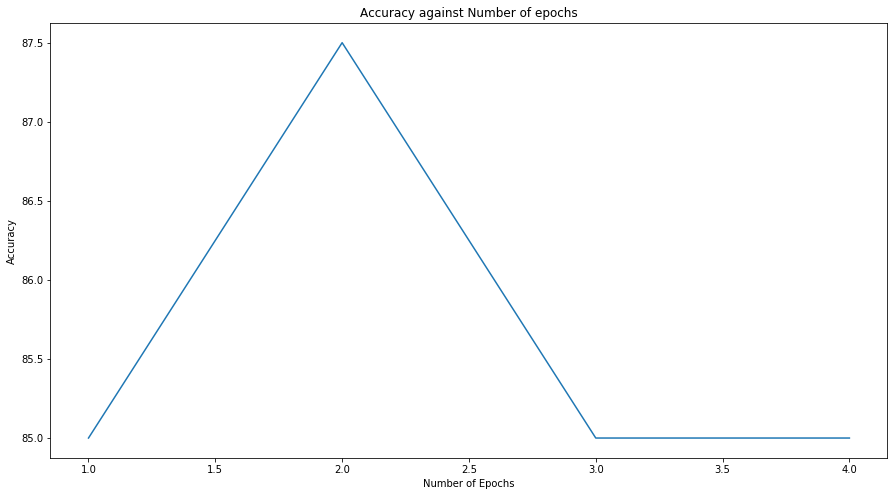

In [63]:
loss=np.asarray(comloss)
acc=np.asarray(accuracy)


epochs=np.linspace(1,4,num=4)
print(epochs)
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy against Number of epochs')
ax1.plot(epochs,acc)

In [ ]:
correct = 0
total = 0
actualclasses=[]
predictedclasses=[]

with torch.no_grad():
    for data in testloader:
        images, labels = data
        actualclasses.append(labels.tolist())
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        predictedclasses.append(predicted.tolist())
#         print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:


actual = [item for sub in actualclasses for item in sub]
prediction = [item for sub in predictedclasses for item in sub]
cm = confusion_matrix(actual, prediction) 

  

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['Infected', 'Normal']) 
ax.yaxis.set_ticklabels(['Infected', 'Normal']) 


print ('Confusion Matrix :')
print(cm) 
print ('Accuracy Score :',accuracy_score(actual, prediction) )
print ('Report : ')
print (classification_report(actual, prediction) )